<a href="https://colab.research.google.com/github/Janggyu-Shin/ML/blob/main/202201915%EC%8B%A0%EC%9E%A5%EA%B7%9C%20ML%EA%B3%BC%EC%A0%9C%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

#챗지피티가 추천해준 불러와야 할 것들

In [83]:
#1: 데이터 불러오기
url = "https://raw.githubusercontent.com/Janggyu-Shin/ML/main/fake_bills.csv"
df = pd.read_csv(url, sep=';')

#2: 정답을 one-hot encoding 하기
encoder = LabelEncoder()
df['is_genuine'] = encoder.fit_transform(df['is_genuine'])

print(df.head(3), df.tail(3)) #처음 세 데이터와 마지막 세 데이터를 확인한다.
#is_genuine 값이 잘 one-hot encoding되었음을 볼 수 있다.

   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   

   length  
0  112.83  
1  113.09  
2  113.16         is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1497           0    171.80       104.01        104.12        5.51       3.36   
1498           0    172.06       104.28        104.06        5.17       3.46   
1499           0    171.47       104.15        103.82        4.63       3.37   

      length  
1497  111.95  
1498  112.25  
1499  112.07  


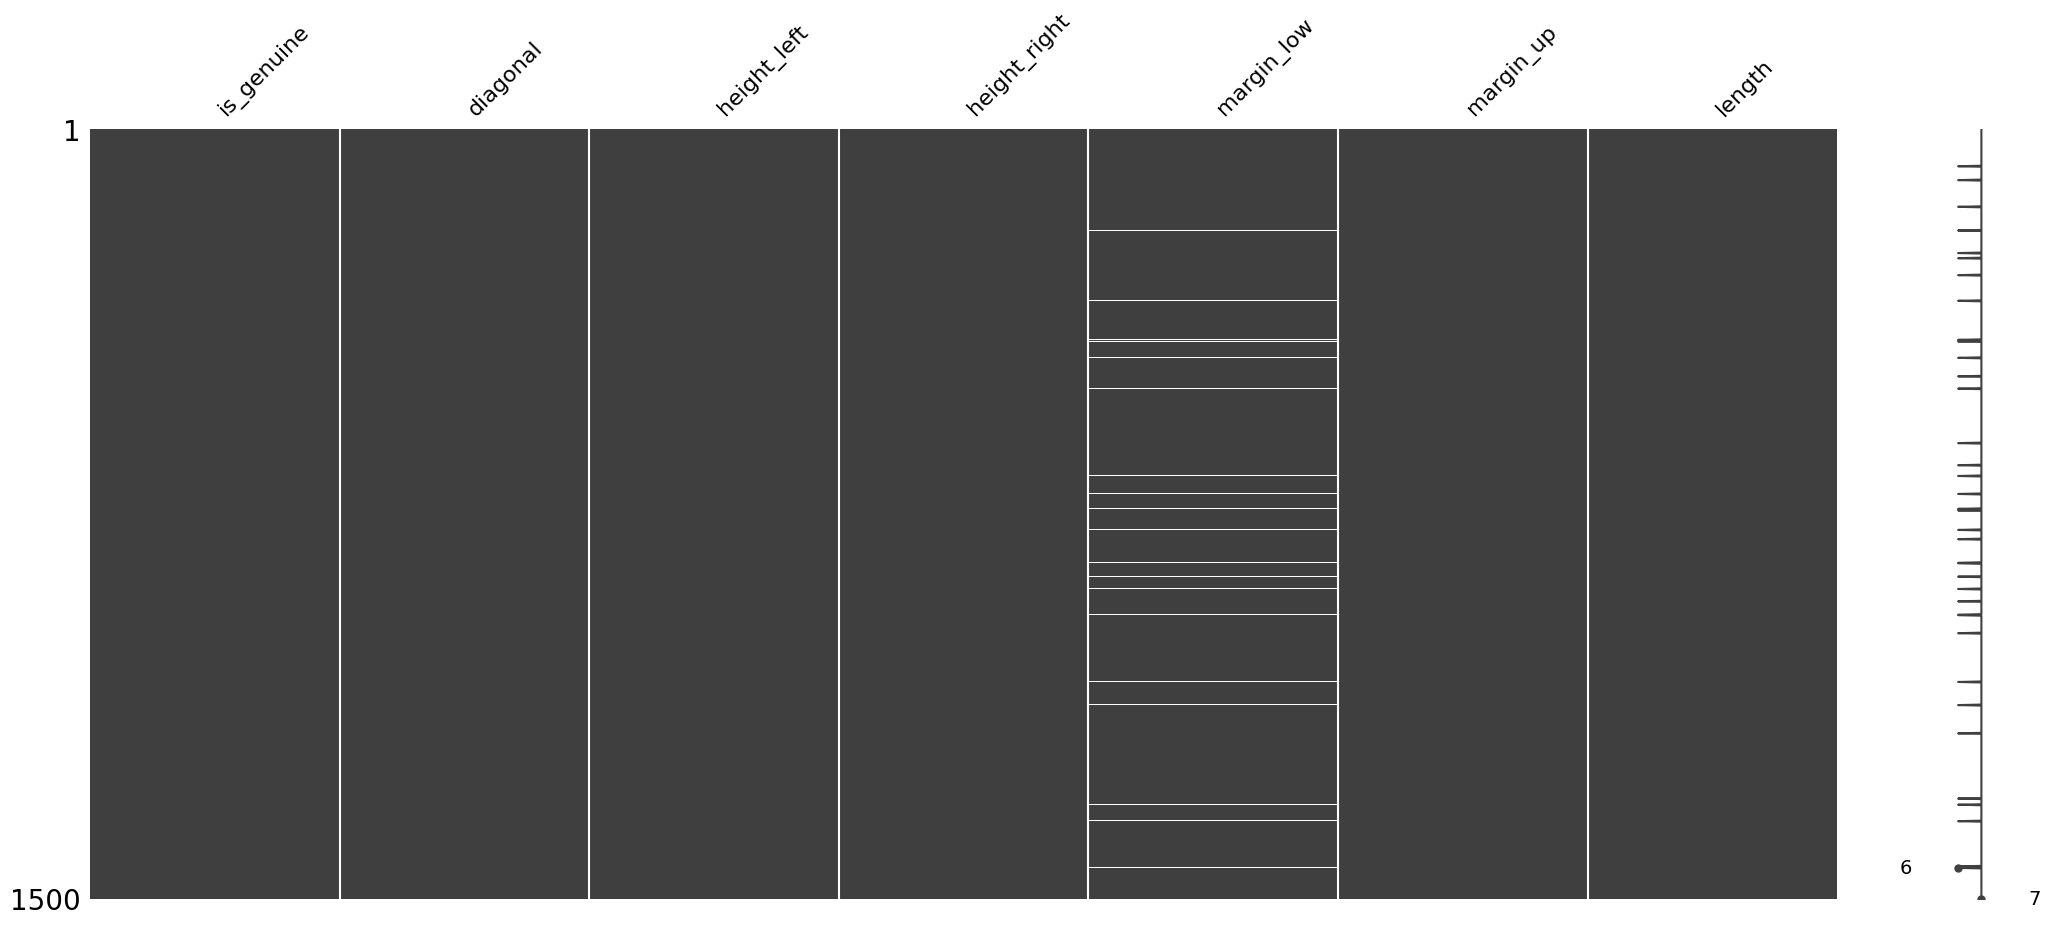

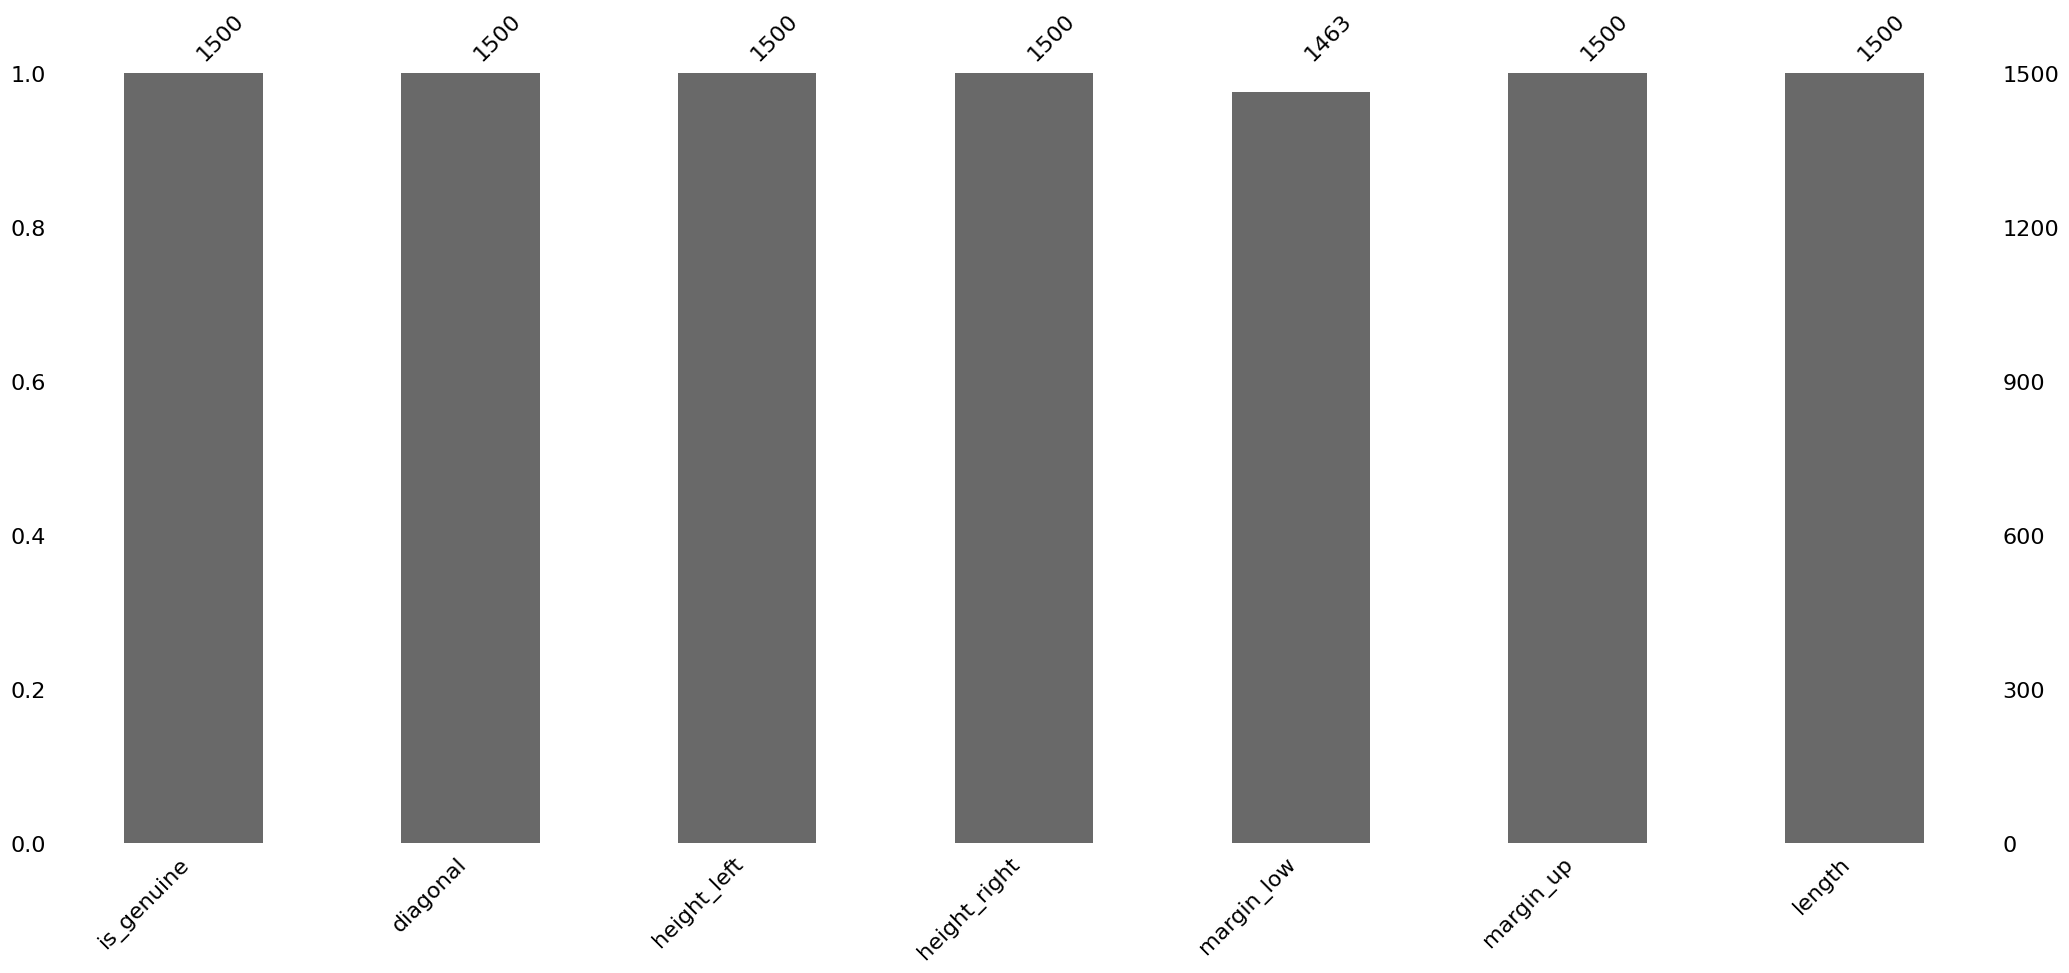

In [71]:
#3: 결측치 확인(matrix/bar)

msno.matrix(df) #matrix를 이용
plt.show()

msno.bar(df) #bar를 이용
plt.show()

In [72]:
missing_values = df.isna().sum() #missing_value를 df에서 결측치 개수의 합으로 정의한다.
print(missing_values) #결측치가 몇 개나 있는지 확인한다. (챗지피티가 알려줌)

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


In [93]:
#4 : kNN으로 사용하여 결측치 채우기
imputer = KNNImputer() #kNNImputer
df_filled = imputer.fit_transform(df) #kNN을 활용하여 결측치를 채운다.

#kNN으로 결측치를 채우면 numpy의 데이터 형태로 바뀌므로 다시 pandas의 데이터 형태로 바꿔준다.
df_filled = pd.DataFrame(df_filled)

#결측치 개수를 다시 확인한다. 모두 채워졌음을 알 수 있다.
missing_values = df_filled.isna().sum() #missing_value를 df_filled에서 결측치 개수의 합으로 재정의한다.
print(missing_values) #근데 왜 0123456 식으로 나오는지는 모르겠다...

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64


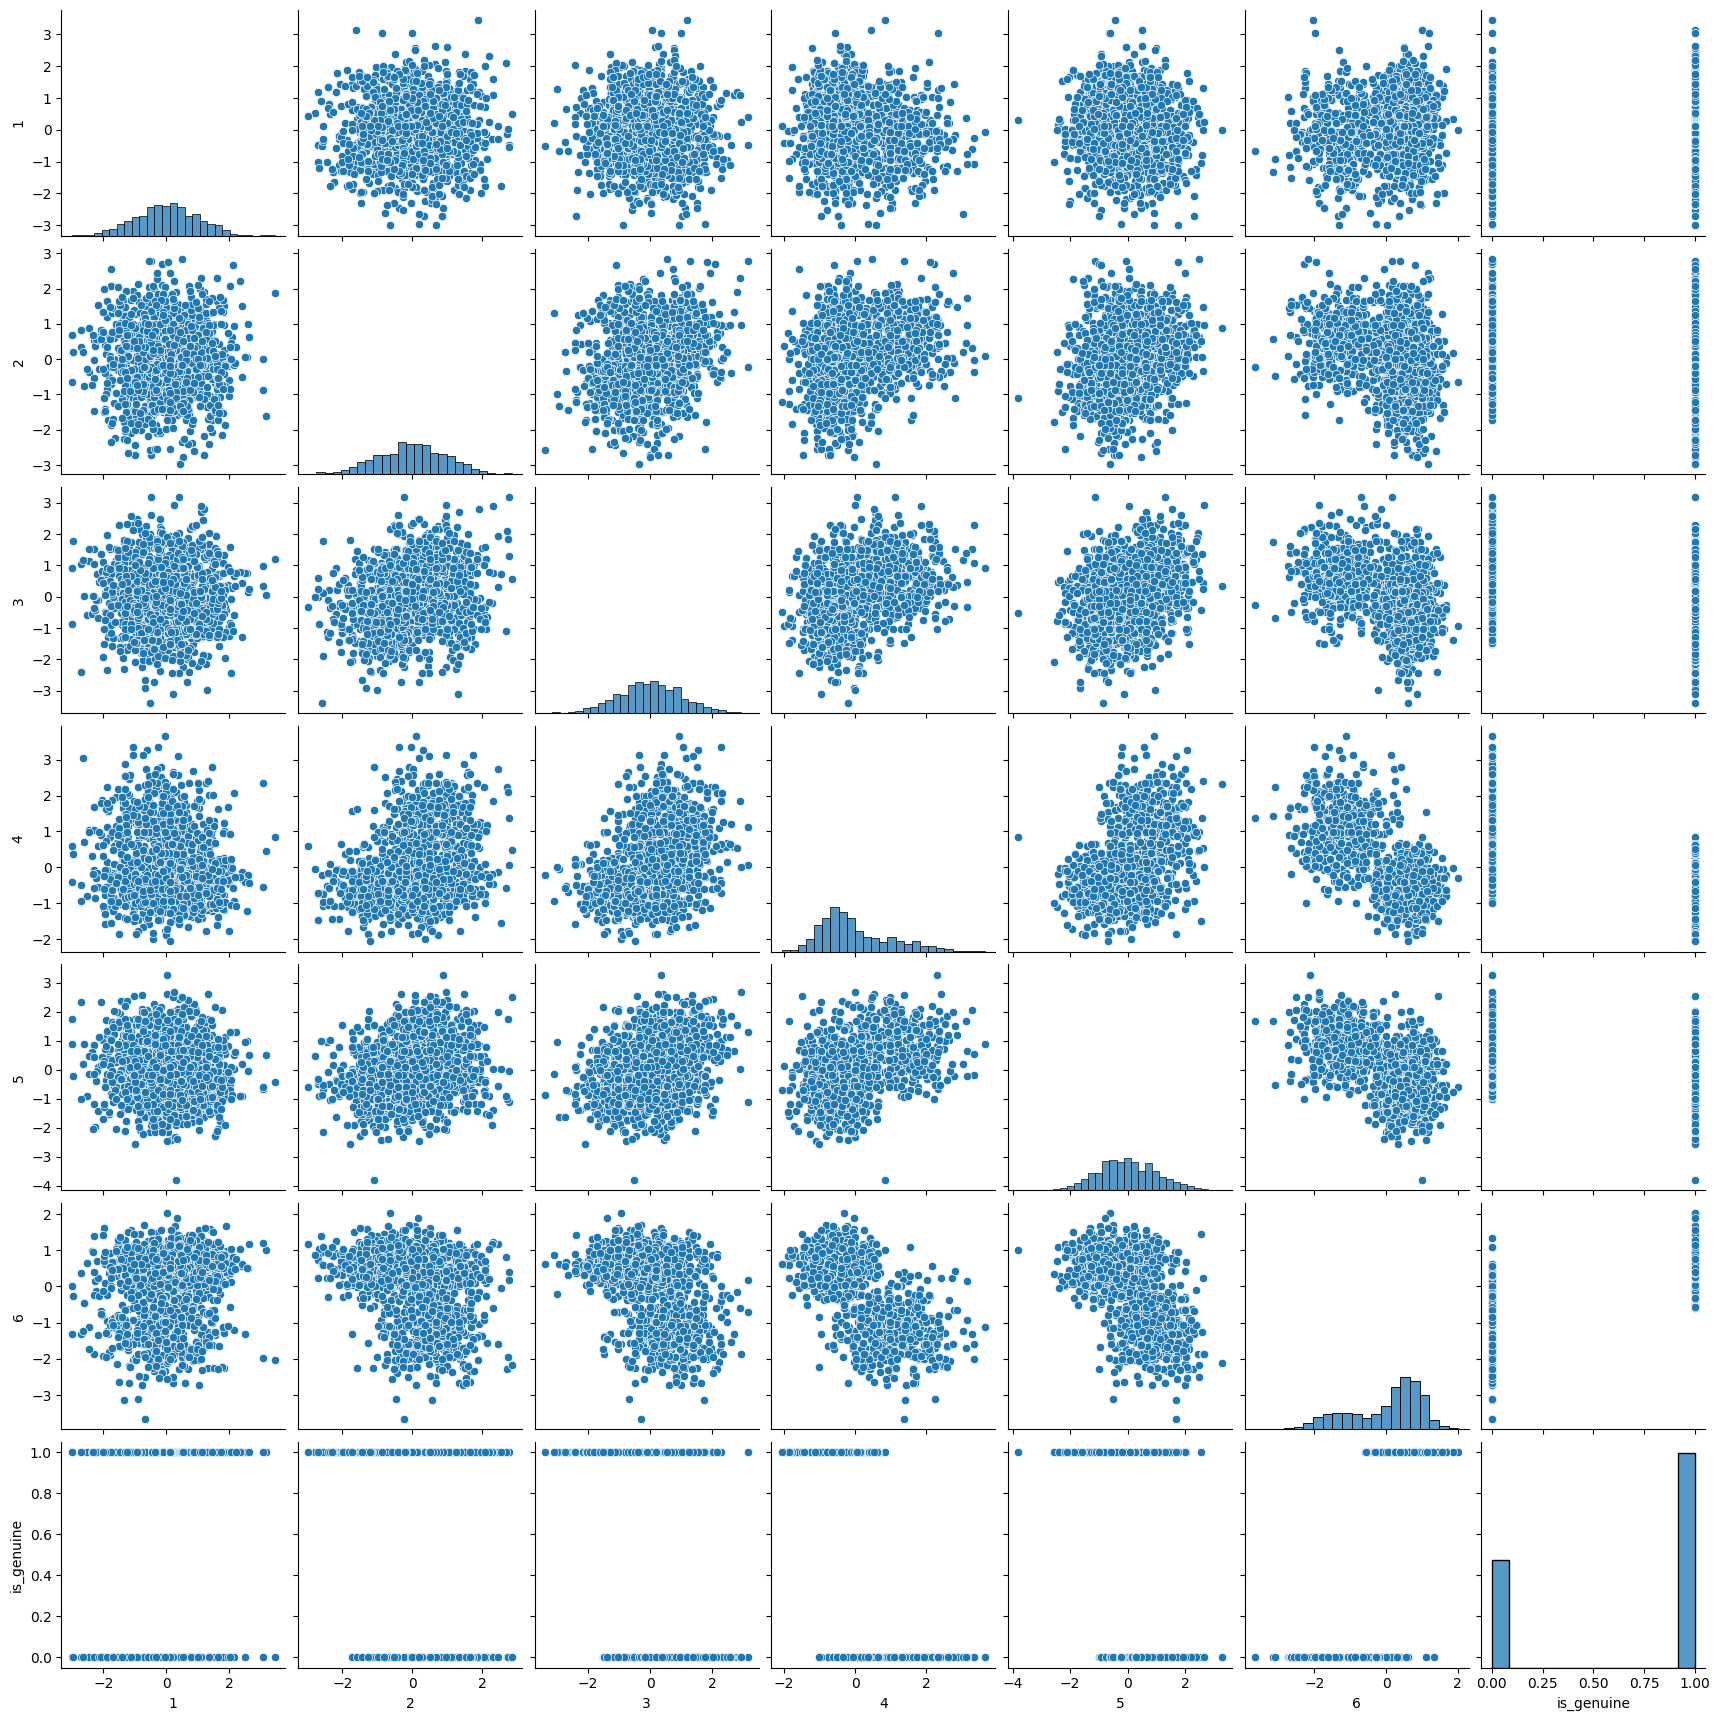

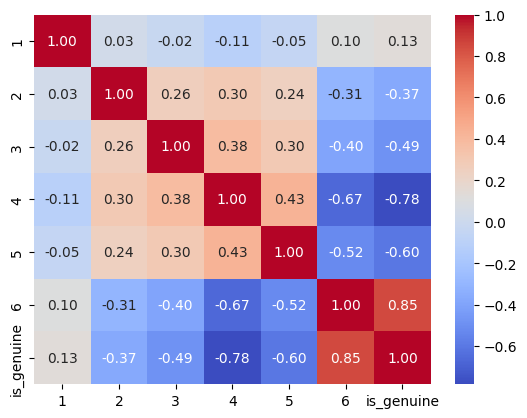

In [87]:
#6:Standarization으로 Normalization
scaler = StandardScaler()
df_filled.iloc[:, 1:] = scaler.fit_transform(df_filled.iloc[:, 1:])
#평균 0, 표준편차 1인 정규 분포로 데이터를 변환
#첫 번째 열을 제외하고 선택하였는데, 이는 true/false가 적힌 행은 데이터 변환에 포함시키지 않기 위함이다.

#7: Train/Test 데이터 분리
X = df_filled.iloc[:, 1:]
y = df['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

#train_test_split(): 데이터를 훈련 데이터와 테스트 데이터로 분할하는 함수
#여기서는 X와 y를 입력으로 받아서 훈련 데이터(X_train, y_train)와 테스트 데이터(X_test, y_test)를 출력
#test_size=0.1: 전체 데이터셋에서 테스트 데이터의 비율
#random_state=42: 무작위로 데이터를 섞을 때 사용되는 시드 값
#stratify=y: 클래스 레이블을 기준으로 계층적 샘플링을 수행

#8: kNN 모델 구축과 Grid Search를 통한 Hyperparameter 튜닝
knn = KNeighborsClassifier() #kNN 분류기 객체 생성
param_grid = {'n_neighbors': np.arange(1, 21)}

#n_neighbors(이웃 수) : 가중치 함수인 weights를 조정
#np.arange(1, 21) : 1부터 20까지의 이웃의 수를 탐색


grid_search = GridSearchCV(knn, param_grid, cv=10) #10-fold-cross validation을 통해 grid search
grid_search.fit(X_train, y_train) #training set에 fitting

best_params = grid_search.best_params_ #최적의 파라미터 값 저장

#4: Training 데이터로 EDA 작업 수행 - 원래는 4번 단계였으나 training data를 활용하기 위해 뒷단계로 옮겼습니다
train_df = pd.concat([X_train, y_train], axis=1) #X_train과 y_train을 합쳐 하나의 데이터셋으로 만듦

sns.pairplot(train_df) #pairplot을 사용해 EDA
plt.show()

correlation_matrix = np.corrcoef(train_df.values.T) #공분산 행렬 히트맵을 이용해 EDA
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=train_df.columns, yticklabels=train_df.columns)
plt.show() #챗지피티가 추천해준 설정값대로 히트맵 출력

In [91]:
#9: 최적의 Hyperparameter를 사용하여 Test 데이터셋에 대한 점수 계산

print("Test 데이터셋에 대한 정확도:", accuracy) #정확도 출력
print("최적의 Hyperparameter:", best_params) #최적의 hyperparameter(이웃 수)출력

Test 데이터셋에 대한 정확도: 0.98
최적의 Hyperparameter: {'n_neighbors': 7}
